<a href="https://colab.research.google.com/github/andydaehn/Drug_Classification/blob/main/Drug_Classify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drug Classification

This analysis will help classify the best drug to use for a particular patient.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, r2_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

# Load the dataset
feat_df = pd.read_csv('drug200.csv')

# Print the first entries of the Drug200 dataset
feat_df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


# Exploratory Data Analysis

In [2]:
# Get basic information
feat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


In [3]:
# Description of numerical values in the data
feat_df.describe()

,Age,Na_to_K
count,200.000000,200.000000
mean,44.315000,16.084485
std,16.544315,7.223956
min,15.000000,6.269000
25%,31.000000,10.445500
50%,45.000000,13.936500
75%,58.000000,19.380000
max,74.000000,38.247000


In [4]:
# Check for duplicate rows
print('Number of duplicated rows:', feat_df.duplicated().sum())

Number of duplicated rows: 0


In [5]:
# Check for NaN values
feat_df.isna().sum()

Age            0
Sex            0
BP             0
Cholesterol    0
Na_to_K        0
Drug           0
dtype: int64

In [6]:
# Check the number of unique values in each column
feat_df.nunique()

Age             57
Sex              2
BP               3
Cholesterol      2
Na_to_K        198
Drug             5
dtype: int64

##Analysis of numerical features

In [7]:
# Combine all numerical features
numerical_cols = feat_df.select_dtypes(include=np.number).columns.to_list()
numerical_cols

['Age', 'Na_to_K']

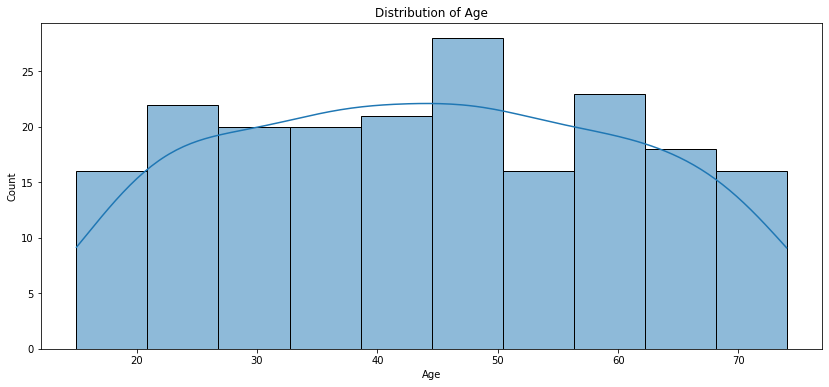

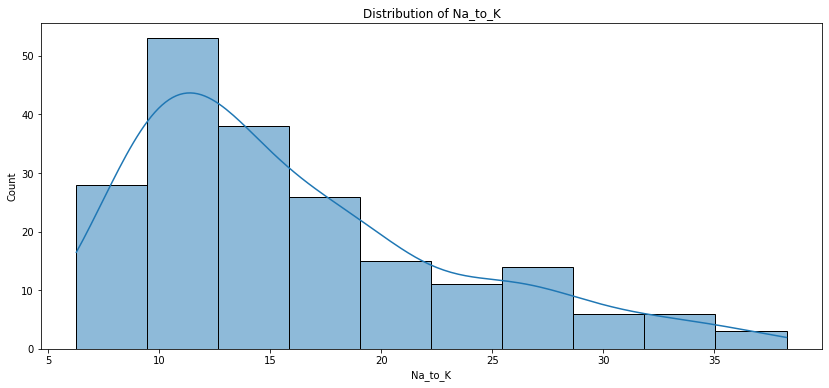

In [8]:
# Plot numerical columns
for col in numerical_cols:
    plt.figure(figsize=(14,6))
    sns.histplot(data=feat_df,x=col,bins=10,kde=True)
    plt.title(f"Distribution of {col}")

#Check skewness and kurtosis of Na_to_K

In [9]:

# Skewness and kurtosis
print("Skewness: %f" % feat_df['Na_to_K'].skew())
print("Kurtosis: %f" % feat_df['Na_to_K'].kurt())

Skewness: 1.039341
Kurtosis: 0.379979


#Na_to_k has a positive skew with many outliers on the tail

#Use log1p to manage the outliers

In [10]:
# Use log1p to adjust the skewness and kurtosis
feat_df['Na_to_K'] = np.log1p(feat_df['Na_to_K'])

# Skewness and kurtosis
print("Skewness: %f" % feat_df['Na_to_K'].skew())
print("Kurtosis: %f" % feat_df['Na_to_K'].kurt())

Skewness: 0.350931
Kurtosis: -0.711525


In [11]:
##Analysis of Categorical features

In [12]:
# Combine all categorical features
categorical_cols=feat_df.select_dtypes(include=object).columns.to_list()
categorical_cols

['Sex', 'BP', 'Cholesterol', 'Drug']

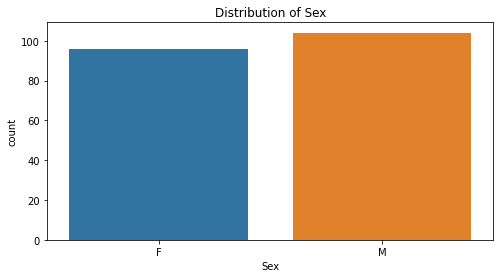

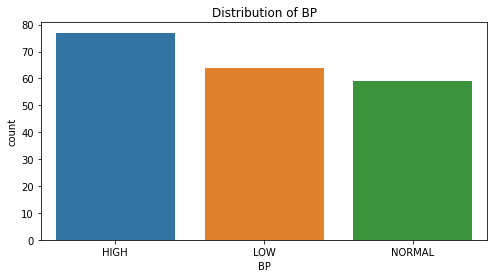

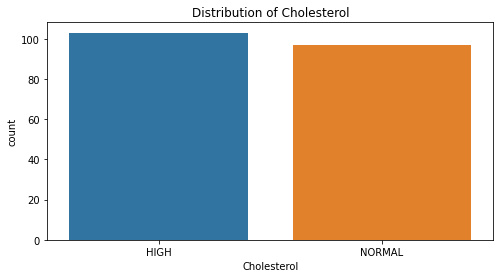

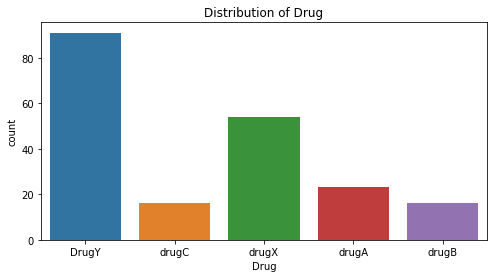

In [13]:
# Plot categorical columns
for col in categorical_cols:
    plt.figure(figsize=(8,4))
    sns.countplot(data=feat_df,x=col)
    plt.title(f"Distribution of {col}")

Drug Y is widely used compared to other drugs, assign class weights to balance this situation.

Bivariate Analysis

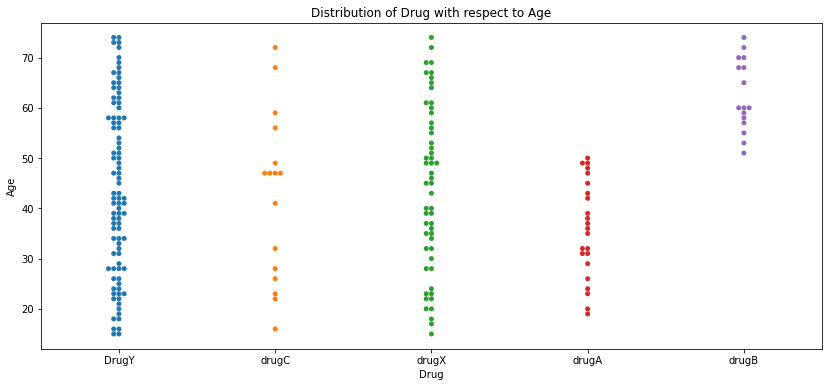

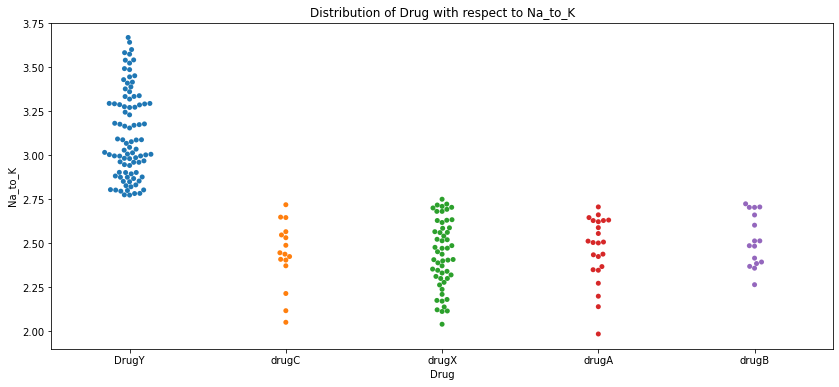

In [14]:
# Bivariate for numerical columns
for col in numerical_cols:
    plt.figure(figsize=(14,6))
    sns.swarmplot(data=feat_df,x='Drug',y=col)
    plt.title(f"Distribution of Drug with respect to {col}")

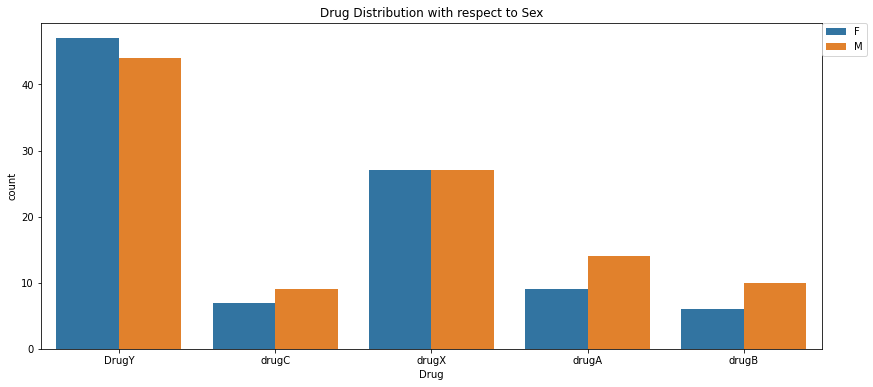

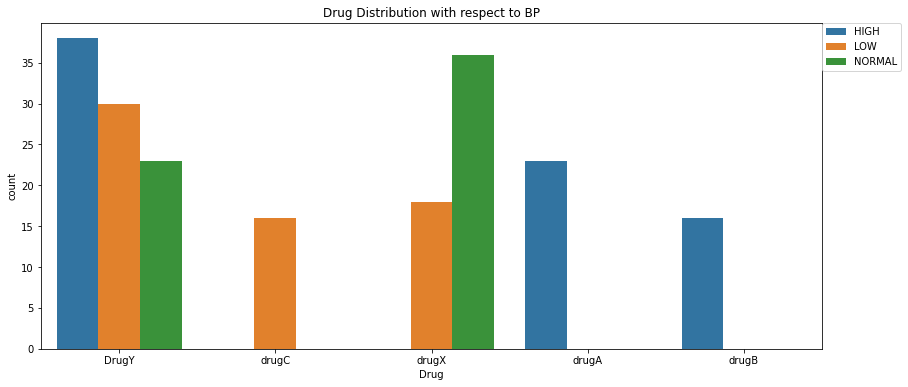

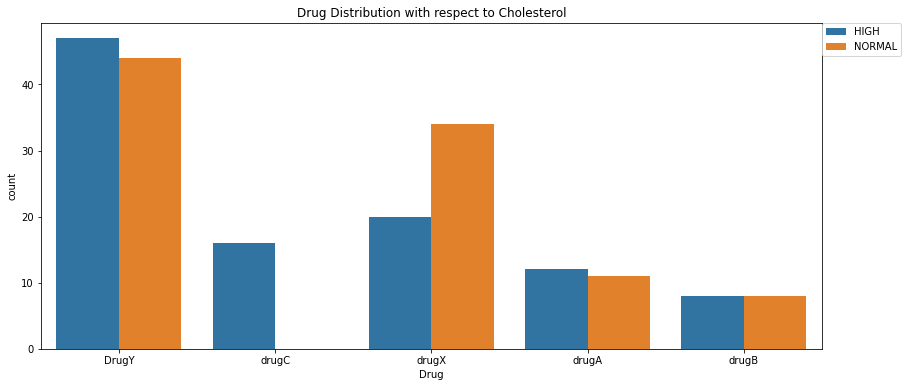

In [15]:
# Bivariate for categorical columns
for col in categorical_cols:
    if col=='Drug':
        continue   
    plt.figure(figsize=(14,6))
    sns.countplot(data=feat_df,x='Drug',hue=col)
    plt.legend(bbox_to_anchor=(1.0,1.0),loc='upper left',borderaxespad=0)
    plt.title(f"Drug Distribution with respect to {col}")

# Encode categorical values

In [16]:
# Split dataframe into features and labels
y_df = feat_df[['Drug']]
X_df = feat_df.drop(columns=['Drug'])


In [17]:


# def label_encoder(x):
#     le = LabelEncoder()
#     drug[x] = le.fit_transform(drug[x])
# categ = ["Sex","BP","Cholesterol","Drug"]

# for l in categ:
#     label_encoder(l)

#X_df = LabelEncoder.fit_transform(X_df)

# # Encoding
# for col in categorical_cols:
#     feat_df[col] = feat_df[col].astype('category').cat.codes

one_hot_encoded_data = pd.get_dummies(X_df, columns = X_df.columns)


In [18]:

X_train, X_test, y_train, y_test = train_test_split(one_hot_encoded_data, y_df, test_size=0.2, random_state=42)

In [19]:
DTC = DecisionTreeClassifier()
DTC.fit(X_train,y_train)
#y_pred = DTC.predict(X_test)
# Making predictions
y_train_pred = DTC.predict(X_train)
y_test_pred = DTC.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)


print('The training accuracy is', (train_accuracy*100),'%')
print('The test accuracy is', (test_accuracy*100),'%')



The training accuracy is 100.0 %
The test accuracy is 55.00000000000001 %


In [20]:
# Split dataframe into features and labels
y_df = feat_df[['Drug']]
X_df = feat_df.drop(columns=['Drug'])
# Change the encoding
# Encoding
for col in categorical_cols:
    feat_df[col] = feat_df[col].astype('category').cat.codes

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=42)

In [22]:
#DTC = DecisionTreeClassifier()
DTC.fit(X_train,y_train)
#y_pred = DTC.predict(X_test)
# Making predictions
y_train_pred = DTC.predict(X_train)
y_test_pred = DTC.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)


print('The training accuracy is', (train_accuracy*100),'%')
print('The test accuracy is', (test_accuracy*100),'%')

ValueError: ignored

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=42)

In [ ]:
RF = RandomForestClassifier
RF.fit(X_train,y_train)
#y_pred = DTC.predict(X_test)
# Making predictions
y_train_pred = RF.predict(X_train)
y_test_pred = RF.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)


print('The training accuracy is', (train_accuracy*100),'%')
print('The test accuracy is', (test_accuracy*100),'%')


In [ ]:
# Plot the import features
feature_importances = pd.DataFrame(DTC.feature_importances_,index=X_df.columns.to_list(),columns=['Importance']).sort_values(by='Importance',ascending=True)
feature_importances.plot(kind='barh',figsize=(14,6));
plt.title("Feature Importance",fontsize=20);